In [1]:
import pandas as pd
import numpy as np
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz, get_sun
import astropy.units as u
from astropy.io import fits
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
from tqdm import tqdm 
from sklearn.preprocessing import MinMaxScaler

# Imprimimos estadísticas resumidas del DataFrame final
pd.set_option('display.float_format', '{:.10f}'.format)

In [2]:
# RT32 location (Ventspils, Latvia)

latitude = 57.5535171694 
longitude = 21.8545525000
elevation = 20  # Elevation in meters (optional)

# Create EarthLocation object with the given location
location = EarthLocation(lat=latitude, lon=longitude, height=elevation)

# Define constants
path = ''
year = 2024
month = 2
day = 15
hour_start = 11
minute_start = 25

az_offset0 = +0.01
el_offset0 = +0.18

az_offset2 = 0.
el_offset2 = 0.

num_scan = 5
step1 = 6.  # arcmin
step2 = 6.
step3 = 6.
step4 = 10.
step5 = 12.
sky = 16. * 4  # arcmin

t_cal = 60.  # seconds
t1 = 40.
t2 = 100.
t3 = 120.
t4 = 120.
t5 = 120.
t_slew = 20.
t_scan = t_cal + t1 + t2 + t3 + t4 + t5 + t_slew + t_cal + t_slew  # duration of scan, seconds
t_spirals = [t1,t2,t3,t4,t5]

file_out = f"{(year - 2000):02d}{month:02d}{day:02d}_{hour_start:02d}{minute_start:02d}"
file_name1 = f"sun_scan_{file_out}.ptf"

In [3]:
def RT32_SUN_PARA(year, month, day, utc):
    # Define constants
    lat_rt32 = 57.5535171694  # RT32 geographic latitude in degrees
    lon_rt32 = 21.8545525000  # RT32 geographic longitude in degrees

    # Ensure utc is an array
    if np.isscalar(utc):
        utime = np.array([utc])
    else:
        utime = np.array(utc)

    q = np.zeros(len(utc))

    for i in range(len(utime)):
        # Define observer's location
        observer_location = location

        # Create Time object
        observation_time = Time(utc[i], format='jd', location=observer_location)

        # Calculate solar alt-az coordinates
        sun_altaz = get_sun(observation_time).transform_to(AltAz(obstime=observation_time, location=observer_location))
        
        # Calculate local sidereal time
        sidereal_time = observation_time.sidereal_time('mean')

        # Calculate hour angle of the Sun
        ha = sidereal_time - sun_altaz.az
   
        # Calculate tangent of parallax angle
        q_tan = np.sin(ha) / (np.tan(lat_rt32) * np.cos(sun_altaz.alt) - 
                              np.sin(sun_altaz.alt) * np.cos(ha))

        
        # Parallax angle in degrees
        q[i] = -np.rad2deg(np.arctan(q_tan)).value # Positive values are to the left, negative to the right
        
    
    # Return result
    if len(q) == 1:
        return q[0]
    else:
        return q


with open(path + file_name1, 'w') as file1:
    file1.write("# Table of horizontal coordinates for Sun scanning\n")
    file1.write("# Celestial Object ID: SUN\n")
    file1.write("# Spiral scanning, number of scans: " + str(num_scan) + "\n")
    file1.write("# Scan time schedule:\n")
    file1.write("# Sun center calibration      60 sec\n")
    file1.write("# 1 spiral turn              40 sec  step 0->6 arcmin\n")
    file1.write("# 2 spiral                   100 sec  step 6->12 arcmin\n")
    file1.write("# 3 spiral                   120 sec step 12->18 arcmin\n")
    file1.write("# 4 spiral                   120 sec step 18-28 arcmin\n")
    file1.write("# 5 spiral                   120 sec step 28-40 arcmin\n")
    file1.write("# Slew to sky 4 Rsun        20 sec\n")
    file1.write("# Sky calibration           60 sec\n")
    file1.write("# Slew to Sun center        20 sec\n")

    # Calculate start time
    start_time = Time(f"{year}-{month:02d}-{day:02d} {hour_start:02d}:{minute_start:02d}:00")

    sun_location = get_sun(start_time)
    az_start, el_start = sun_location.transform_to(AltAz(obstime=start_time, location=location)).az, \
                         sun_location.transform_to(AltAz(obstime=start_time, location=location)).alt

    file1.write(f"# Az@Start Time      : {az_start:.5f} deg.\n")
    file1.write(f"# El@Start Time      : {el_start:.5f} deg.\n")
    file1.write(f"# Start Time (UTC+0) : {start_time.iso}\n")

    utime_start = start_time.jd  # start time in JD
    time_session = num_scan * t_scan / 3600. / 24  # session duration in hours
    utime_mean = utime_start + time_session / 2.  # mean UT time of session
    utime_end = utime_start + time_session  # end UT time of session
    file1.write(f"# End Time, (UTC), hours: {Time(utime_end, format='jd').iso}\n")
    file1.write(f"# Mean observation time (UTC): {Time(utime_mean, format='jd').iso}\n")
    file1.write(f"# Az offset          : {az_offset0} deg.\n")
    file1.write(f"# El offset          : {el_offset0} deg.\n")
    file1.write("#!!! Offset of the antenna pointing system must be set 0 !!!\n")
    file1.write("\n[Interpolation]\n")
    file1.write("Newton\n")
    file1.write("\n[Load Mode]\n")
    file1.write("New\n")
    file1.write("\n[Start Time]\n")
    file1.write(f"{start_time.iso}\n")
    file1.write("\n[Table Data]\n")
    file1.write("#  Time   Az source [degr.]     El source[degr.]\n")

    # Calculate coordinates
    x = np.zeros(700)
    y = np.zeros(700)

    # Calibration Sun center

    for i in range(int(t_cal)):
        x[i] = 0.
        y[i] = 0.

    # 1 turn
    for i in range(int(t1)):
        i0 = int(t_cal) 
        fi = i * 360. / t1
        r = i * step1 / t1
        x[int(i + i0)] = r * np.cos(np.deg2rad(fi))
        y[int(i + i0)] = r * np.sin(np.deg2rad(fi))

    # 2 turn
    for i in range(int(t2)):
        i0 = int(t_cal) + int(t1)
        fi = i * 360. / t2
        r = step1 + i * (step2 / t2)
        x[i + i0] = r * np.cos(np.deg2rad(fi))
        y[i + i0] = r * np.sin(np.deg2rad(fi))

    # 3 turn
    for i in range(int(t3)):
        i0 = int(t_cal) + int(t1) + int(t2)
        fi = i * 360. / t3
        r = step1 + step2 + i * (step3 / t3)
        x[i + i0] = r * np.cos(np.deg2rad(fi))
        y[i + i0] = r * np.sin(np.deg2rad(fi))

    # 4 turn
    for i in range(int(t4)):
        i0 = int(t_cal) + int(t1) + int(t2) + int(t3)
        fi = i * 360. / t4
        r = step1 + step3 + step3 + (i * step4 / t4)
        x[i + i0] = r * np.cos(np.deg2rad(fi))
        y[i + i0] = r * np.sin(np.deg2rad(fi))

    # 5 turn
    for i in range(int(t5)):
        i0 = int(t_cal) + int(t1) + int(t2) + int(t3) + int(t4)
        fi = i * 360. / t5
        r = step1 + step2 + step3 + step4 + i * (step5 / t5)
        x[i + i0] = r * np.cos(np.deg2rad(fi))
        y[i + i0] = r * np.sin(np.deg2rad(fi))

    # slew to clibration, Sky
    for i in range(int(t_slew)):
        i0 = int(t_cal) + int(t1) + int(t2) + int(t3) + int(t4) + int(t5)
        y[i + i0] = 0.
        x0 = step1 + step2 + step3 + step4 + step5
        x[i + i0] = x0 + i * (sky - x0) / t_slew

    # calibration sky
    for i in range(int(t_cal)):
        i0 = int(t_cal) + int(t1) + int(t2) + int(t3) + int(t4) + int(t5) + int(t_slew)
        x[i + i0] = sky
        y[i + i0] = 0.

    # Seventh loop: slew to Sun center
    for i in range(int(t_slew)):
        i0 = int(t_cal) + int(t1) + int(t2) + int(t3) + int(t4) + int(t5) + int(t_slew) + int(t_cal)
        y[i + i0] = 0.
        x[i + i0] = (int(t_slew) - i - 1) * sky / t_slew

        xx = np.zeros(num_scan * int(t_scan))
        yy = np.zeros(num_scan * int(t_scan))

    for j in range(num_scan):
        ff = j * (360.0 / num_scan)
        for i in range(int(t_scan)):
            ii = j * int(t_scan) + i
            xx[ii] = x[i] * np.cos(np.deg2rad(ff)) - y[i] * np.sin(np.deg2rad(ff))
            yy[ii] = x[i] * np.sin(np.deg2rad(ff)) + y[i] * np.cos(np.deg2rad(ff))
            
    
    utc = utime_start + np.arange(num_scan * t_scan) / 3600. / 24
    q = RT32_SUN_PARA(year, month, day, utc)

    xx1 = xx * np.cos(np.deg2rad(q)) - yy * np.sin(np.deg2rad(q))
    yy1 = xx * np.sin(np.deg2rad(q)) + yy * np.cos(np.deg2rad(q))

    
    az_sun = sun_location.transform_to(AltAz(obstime=Time(utc, format='jd'), location=location)).az.deg
    el_sun = sun_location.transform_to(AltAz(obstime=Time(utc, format='jd'), location=location)).alt.deg

    az_anten = az_sun + xx1 / np.cos(np.deg2rad(el_sun)) / 60.
    el_anten = el_sun + yy1 / 60.

   
    for i in range(len(utc)):
        file1.write(f"{Time(utc[i], format='jd').iso}.00 \t\t {az_anten[i]:.5f} \t\t {el_anten[i]:.5f}\n")

print('-------------------------------------------------------------')
print('Saved: ', file_name1, "  ",  len(utc), "  points")


-------------------------------------------------------------
Saved:  sun_scan_240215_1125.ptf    3300   points


In [4]:
# Create DataFrame
sunPositionDf = pd.DataFrame({'UTC': utc,'SunX': xx1, 'SunY': yy1})


# Convertir Julian_Time a objetos Time de astropy
time = Time(sunPositionDf['UTC'], format='jd')

# Calcular las horas decimales con precisión de milisegundos para cada valor
decimal_hours = []

for datetime_obj in time.datetime:
    hour = datetime_obj.hour
    minute = datetime_obj.minute
    second = datetime_obj.second
    microsecond = datetime_obj.microsecond
    decimal_hour = hour + minute / 60 + second / 3600 + microsecond / 3600000000
    decimal_hours.append(decimal_hour)    

# Agregar las horas decimales al DataFrame
sunPositionDf['UTC'] =  np.array(decimal_hours).astype(float)

print(sunPositionDf.head())

            UTC         SunX         SunY
0 11.4166666678 0.0000000000 0.0000000000
1 11.4169444442 0.0000000000 0.0000000000
2 11.4172222206 0.0000000000 0.0000000000
3 11.4174999967 0.0000000000 0.0000000000
4 11.4177777842 0.0000000000 0.0000000000


In [5]:
def bintable_to_pandas(file_path, hdu_number):
    try:
        # Leer la tabla binaria del archivo FITS
        table = Table.read(file_path, hdu=hdu_number)

        # Crear una lista para almacenar las filas descomprimidas
        rows = []

        # Iterar sobre cada fila de la tabla
        for row_index, row in enumerate(table):
            # Crear un diccionario para la fila original
            row_dict = {}
            # Iterar sobre cada columna
            for colname in table.colnames:
                # Verificar si la columna contiene un array y si es la primera fila
                if isinstance(row[colname], np.ndarray) and row_index == 0:
                    # Si es la primera fila y es un array, agregar cada elemento como una fila adicional
                    for i, value in enumerate(row[colname]):
                        new_row_dict = row_dict.copy()  # Copiar el diccionario de la fila original
                        new_row_dict[colname] = value  # Actualizar el valor de la columna con el elemento del array
                        rows.append(new_row_dict)  # Agregar la fila a la lista de filas
                else:
                    # Si no es un array o no es la primera fila, agregar el valor a la fila original
                    row_dict[colname] = row[colname]
            # Agregar la fila original a la lista de filas
            rows.append(row_dict)

        # Convertir la lista de diccionarios en una nueva tabla
        table_descompressed = Table(rows)

        # Convertir la tabla filtrada en un DataFrame de Pandas
        df = table_descompressed.to_pandas()       

        return df
    except Exception as e:
        print("Error:", e)
        return None



In [6]:
fit_file_path = "test2.fit"
hdu_number = 1  # Número de la extensión que contiene la tabla binaria

# Convierte la tabla binaria a un DataFrame de Pandas
data_df = bintable_to_pandas(fit_file_path, hdu_number)

print(data_df.describe())

        LCP 01 4.07GHZ   LCP 04 6.42GHZ   LCP 07 8.40GHZ   LCP 09 9.80GHZ  \
count  1872.0000000000  1872.0000000000  1872.0000000000  1872.0000000000   
mean  17737.5219017094 21194.8723290598 22459.6447649573 22921.1447649573   
std     469.8873997180   305.0346367262   171.8903587763   108.9282116868   
min   17285.0000000000 20890.0000000000 22280.0000000000 22808.0000000000   
25%   17340.0000000000 20929.0000000000 22305.0000000000 22827.0000000000   
50%   17527.5000000000 21060.0000000000 22379.5000000000 22871.0000000000   
75%   18074.0000000000 21475.0000000000 22646.0000000000 23035.0000000000   
max   19696.0000000000 22710.0000000000 23241.0000000000 23863.0000000000   

       LCP 11 11.90GHZ   RCP 01 4.07GHZ   RCP 04 6.42GHZ   RCP 07 8.40GHZ  \
count  1872.0000000000  1872.0000000000  1872.0000000000  1872.0000000000   
mean  15044.6848290598 17459.1901709402 22618.7986111111 21558.5325854701   
std     108.6849335361   517.6658030473   306.4793905360   189.3222038039  

     UTC_RCP_11  RCP_11_4_11_90GHZ
0 11.3420394444    7375.0000000000
1 11.3426150000    7369.0000000000
2 11.3431875000    7363.0000000000
3 11.3437625000    7353.0000000000
4 11.3443350000    7353.0000000000


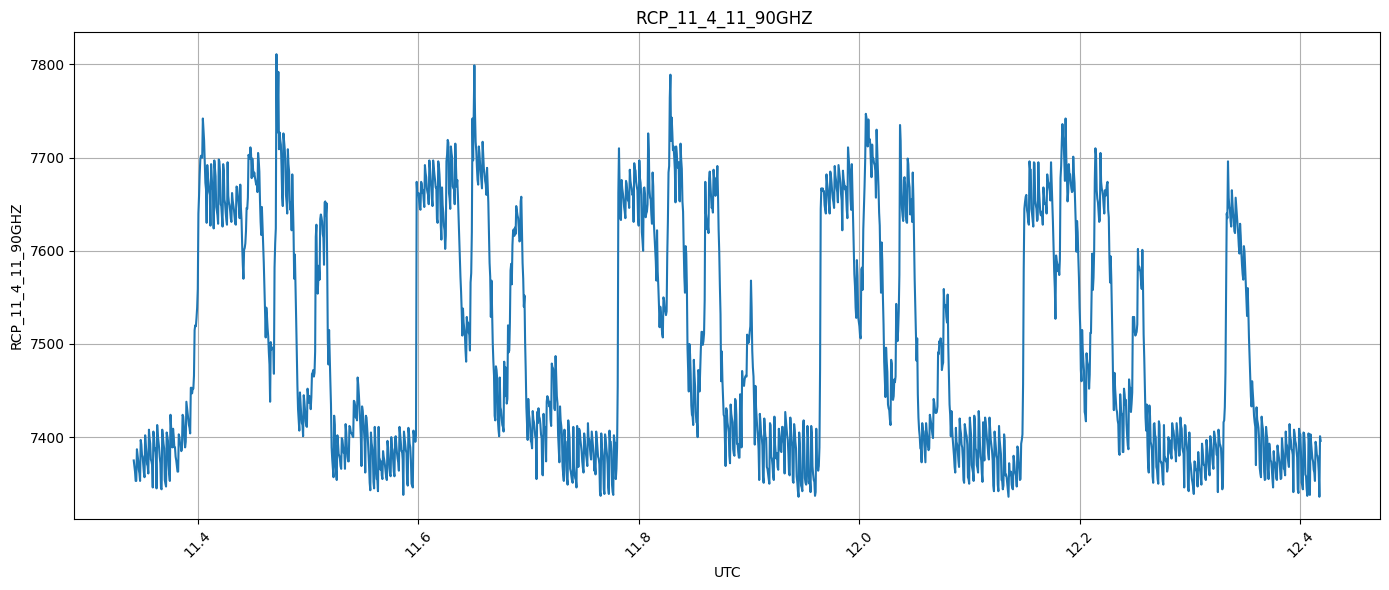

In [18]:
# Extracting columns and dropping NaN values
UTC_RCP_11 = data_df['UTC RCP 11'].dropna()
RCP_11_4_11_90GHZ = data_df['RCP 11 11.90GHZ'].dropna()


# Creating DataFrame with two columns
RCP_11_df = pd.DataFrame({'UTC_RCP_11': UTC_RCP_11.values, 'RCP_11_4_11_90GHZ': RCP_11_4_11_90GHZ.values})

# Printing the first few rows of the DataFrame
print(RCP_11_df.head())

# Trama de los datos
plt.figure(figsize=(14, 6))
plt.plot(RCP_11_df['UTC_RCP_11'], RCP_11_df['RCP_11_4_11_90GHZ'], linestyle='-')
plt.xlabel('UTC')
plt.ylabel('RCP_11_4_11_90GHZ')
plt.title('RCP_11_4_11_90GHZ ')
plt.grid(True)
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mayor claridad
plt.tight_layout()
plt.show()

In [8]:
# Crear un DataFrame vacío para almacenar los resultados interpolados
interpolated_df = pd.DataFrame()

numInter = 2
# Iterar sobre las filas del DataFrame original con tqdm para la barra de progreso
for i in tqdm(range(len(sunPositionDf) - 1), desc="Interpolating Data"):
    # Interpolar numInter veces entre cada fila
    interpolated_data = sunPositionDf.iloc[i].interpolate(method='linear', limit_direction='forward', limit_area='inside', axis=0).to_frame().T
    for j in range(1, numInter):
        interpolated_row = sunPositionDf.iloc[i] + (sunPositionDf.iloc[i+1] - sunPositionDf.iloc[i]) * (j / numInter)
        interpolated_data = pd.concat([interpolated_data, interpolated_row.to_frame().T])
    interpolated_df = pd.concat([interpolated_df, interpolated_data])

# Agregar la última fila del DataFrame original
interpolated_df = pd.concat([interpolated_df, sunPositionDf.iloc[-1].to_frame().T])

# Restablecer los índices
interpolated_df.reset_index(drop=True, inplace=True)



Interpolating Data:   0%|          | 0/3299 [00:00<?, ?it/s]

Interpolating Data: 100%|██████████| 3299/3299 [00:11<00:00, 279.18it/s]


In [9]:
# Generamos una serie con 999 valores interpolados entre cada par de valores en cada columna
columns = sunPositionDf.columns
interpolated_values = np.empty((sunPositionDf.shape[0] * 1000, sunPositionDf.shape[1]))

for i, col in enumerate(columns):
    for j in range(len(sunPositionDf)-1):
        interpolated_values[j*1000:(j+1)*1000, i] = np.linspace(sunPositionDf.iloc[j][col], sunPositionDf.iloc[j+1][col], 1000)

# Creamos un nuevo DataFrame con los valores interpolados
interpolated_df = pd.DataFrame(interpolated_values, columns=columns)

# Imprimimos estadísticas resumidas del DataFrame final
pd.set_option('display.float_format', '{:.10f}'.format)
print(interpolated_df.describe())

                     UTC               SunX               SunY
count 3300000.0000000000 3300000.0000000000 3300000.0000000000
mean       11.8712626696      -0.0017625327       0.0038110040
std         0.3356748477      20.6860329973      20.6836054548
min         0.0000000000     -60.4283809552     -63.9858262570
25%        11.6455555558      -9.9866985825     -11.6378151476
50%        11.8747222200       0.0000000000       0.0000000000
75%        12.1038888953       9.9058001518       9.9920984781
max        12.3330555594      61.3145328782      52.6190360953


In [10]:
print(sunPositionDf.describe())
print(RCP_11_df.describe())

                  UTC            SunX            SunY
count 3300.0000000000 3300.0000000000 3300.0000000000
mean    11.8748611124   -0.0017625327    0.0038110040
std      0.2646589641   20.6919640052   20.6895363325
min     11.4166666678  -60.4283809552  -63.9858262570
25%     11.6457638881   -9.9948465036  -11.6146297392
50%     11.8748611082    0.0000000000    0.0000000000
75%     12.1039583394    9.8611902539    9.9619275488
max     12.3330555594   61.3145328782   52.6190360953
           UTC_RCP_11  RCP_11_4_11_90GHZ
count 1872.0000000000    1872.0000000000
mean    11.8801630821    7498.8311965812
std      0.3109526615     126.2227774824
min     11.3420394444    7336.0000000000
25%     11.6110954861    7389.0000000000
50%     11.8801501389    7441.0000000000
75%     12.1492111806    7637.0000000000
max     12.4183319444    7811.0000000000


In [11]:
# Realiza la fusión de los DataFrames utilizando diferentes nombres de columna
RCP_11_df['UTC_RCP_11'] = RCP_11_df['UTC_RCP_11'].astype('float64').round(3)
interpolated_df['UTC'] = interpolated_df['UTC'].round(3)
merged_df = pd.merge(interpolated_df, RCP_11_df, left_on='UTC', right_on='UTC_RCP_11')

# Imprime el DataFrame fusionado
print(merged_df.describe())

                     UTC               SunX               SunY  \
count 5733999.0000000000 5733999.0000000000 5733999.0000000000   
mean       11.8748262092      -0.0040396487       0.0038508501   
std         0.2644996417      20.6973570252      20.6951226849   
min        11.4170000000     -60.4283809552     -63.9858262570   
25%        11.6460000000      -9.9704943403     -11.6320667388   
50%        11.8750000000       0.0000000000       0.0000000000   
75%        12.1040000000       9.9048193696      10.0488316525   
max        12.3330000000      61.3145328782      52.6190360953   

              UTC_RCP_11  RCP_11_4_11_90GHZ  
count 5733999.0000000000 5733999.0000000000  
mean       11.8748262092    7507.6674326242  
std         0.2644996417     126.4157215229  
min        11.4170000000    7336.0000000000  
25%        11.6460000000    7395.0000000000  
50%        11.8750000000    7466.0000000000  
75%        12.1040000000    7644.0000000000  
max        12.3330000000    7811.0000

In [12]:
# Agrupar y calcular la media de Power para cada combinación única de SunX y SunY
grouped = merged_df.groupby(['SunX', 'SunY']).agg({'RCP_11_4_11_90GHZ': 'mean'}).reset_index()

# Normalizar todas las columnas para que estén en el rango de 0 a 1
scaler = MinMaxScaler()
grouped['RCP_11_4_11_90GHZ'] = scaler.fit_transform(grouped[['RCP_11_4_11_90GHZ']])



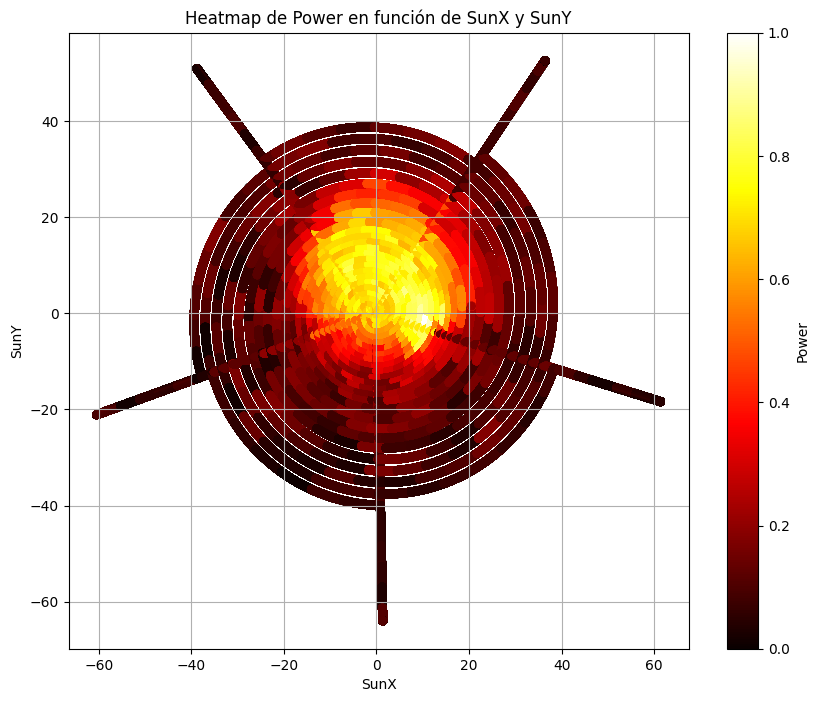

In [13]:
# Crear el heatmap
plt.figure(figsize=(10, 8))
plt.scatter(grouped['SunX'], grouped['SunY'], c=grouped['RCP_11_4_11_90GHZ'], cmap='hot',s=30)
plt.colorbar(label='Power')
plt.xlabel('SunX')
plt.ylabel('SunY')
plt.title('Heatmap de Power en función de SunX y SunY')
plt.grid(True)  # Mostrar la cuadrícula para mayor claridad
plt.show()

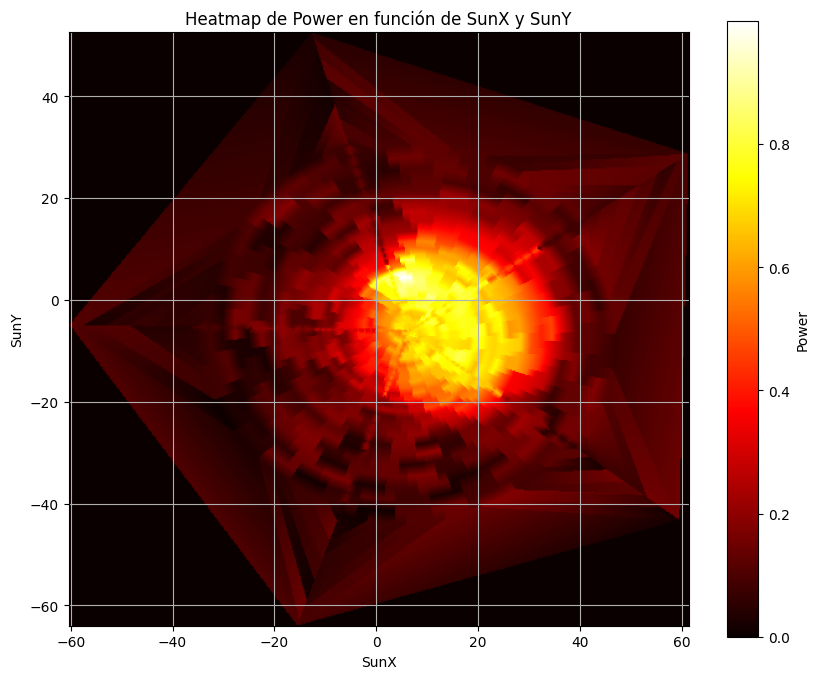

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import make_lupton_rgb
from scipy.interpolate import griddata

# Datos de ejemplo
SunX = grouped['SunX']
SunY = grouped['SunY']
Power = grouped['RCP_11_4_11_90GHZ']

# Definir el rango de la cuadrícula
min_x, max_x = SunX.min(), SunX.max()
min_y, max_y = SunY.min(), SunY.max()

# Crear una cuadrícula que cubra un rango más amplio
grid_x, grid_y = np.mgrid[min_x:max_x:500j, min_y:max_y:500j]

# Interpolar los puntos dispersos en la cuadrícula
grid_power = griddata((SunX, SunY), Power, (grid_x, grid_y), method='linear', fill_value=0)

# Crear la imagen
plt.figure(figsize=(10, 8))
plt.imshow(grid_power, extent=(min_x, max_x, min_y, max_y), cmap='hot', origin='lower')
plt.colorbar(label='Power')
plt.xlabel('SunX')
plt.ylabel('SunY')
plt.title('Heatmap de Power en función de SunX y SunY')
plt.grid(True)  # Mostrar la cuadrícula para mayor claridad
plt.show()
